# Custom TensorFlow & TensorFlow Lite Görüntü Sınıflandırma Modeli Eğitimi

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/120bsVLZoJ0fRu-gkvZnvCXqqIREev5vN#scrollTo=N92nbqj2WRD_)

## Giriş


Bu not defterinde TensorFlow ve TensorFlow Lite için özel bir görüntü sınıflandırmanın nasıl hazırlandığı anlatılacak ve kodlarla gösterilecektir.

Öncelikle sınıflandırılmak istenen görüntüler hazırlanmalı ve sınıflara göre klasör yapısına koyulmalıdır. 
Örnek klasörleme örneği aşağıdaki görselde verilmiştir.

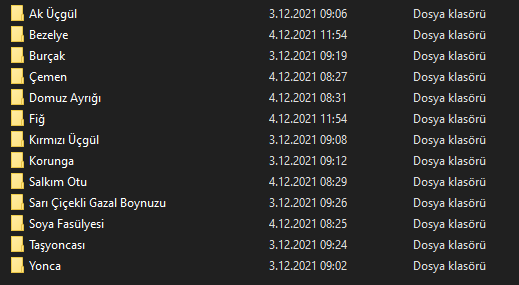

**Önemli!** 

Modelin iyi eğitilebilmesi için görüntü sayılarının fazla ve dengeli olduğuna emin olun! Örnek olarak her bir sınıf için en az 50 adet görüntü elde edin. Görüntülerde denge sağlamak için her bir sınıfın görüntü sayısı yakın olmalı, bir sınıfta 10 fotoğraf varken başka bir sınıfta 100 fotoğraf bulunmamalıdır.

### Roboflow

[Roboflow web sitesi](https://roboflow.com), görüntü verilerimizi yükleyip görüntü sınıflandırma, nesne tanıma gibi uygulamalarda kullanabileceğimiz veri seti oluşturmamızı sağlayan bir araçtır. Bu modelde kullanmamızın amacı, görüntüleri boyutlandırmak, uyumsuz olan uzantıya sahip olan görüntüleri kaldırmak, görüntüler üzerinde ön işleme ve veri artırımı yapmak içindir. 

**Veri Seti Oluşturma**

Veri seti oluşturmak için öncelikle siteye giriş yapmalısınız. Giriş yaptıktan sonra ise aşağıdaki ekran görüntüsündeki sarı ile işaretli alana tıklanılmalıdır.

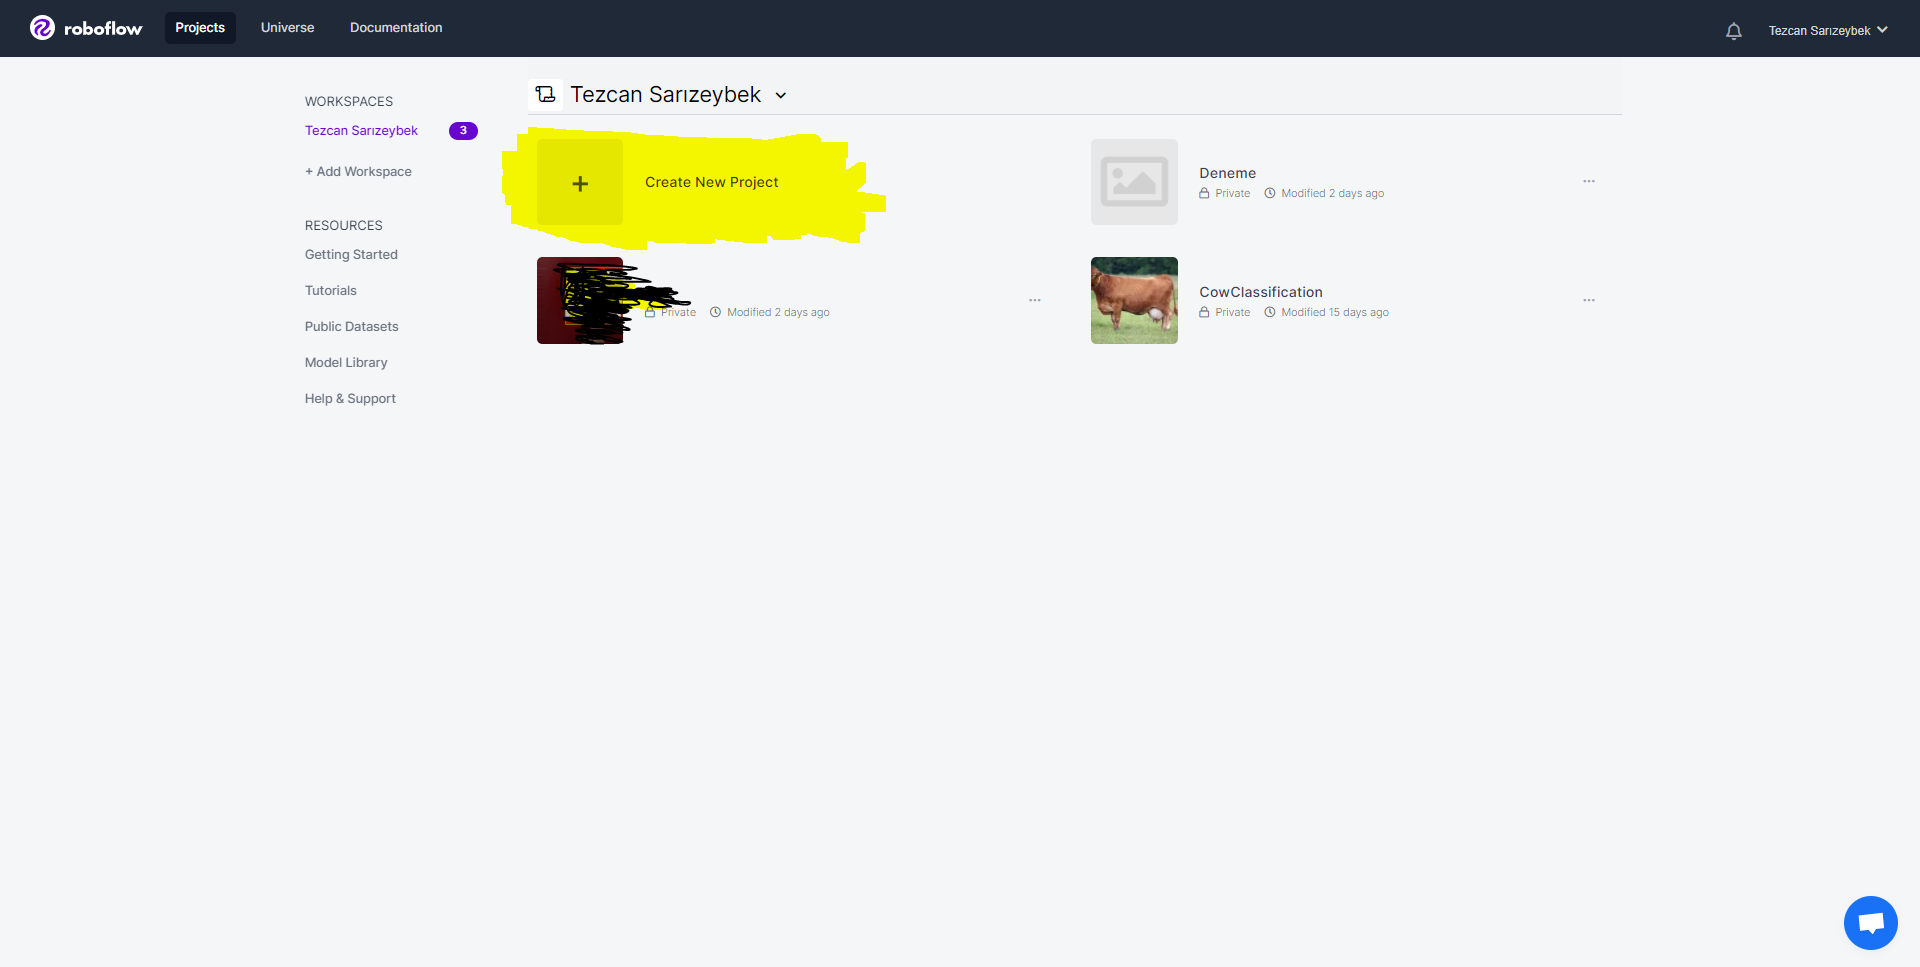

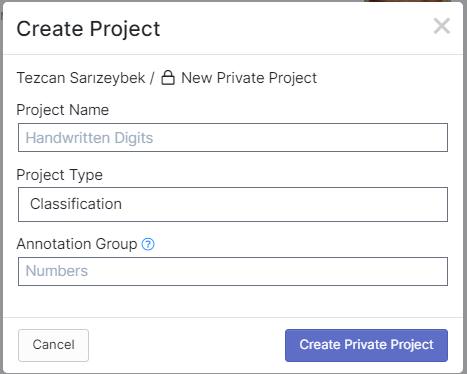

Proje ismi ve sınıflandırma grup ismi belirlendikten sonra proje tipi olarak **Classification** seçilmeli ve **Create Private Project** butonuna tıklanılmalıdır.

Karşımıza çıkan ekranda görüntüleri klasörleriyle beraber atmalı ve **Finish Uploading** butonuna tıklamalıyız. Train-Test ve Validation ayırma kısmında Test kısmı bu kod için %0 olmalı, diğer oranları isteğimize bağlı değiştirebiliriz. Bu çalışmada %20 doğrulama, %80 eğitim olarak belirlenmiştir.

Ardından solda bulunan **Dataset** bölümüne gelmeli ve Preprocessing kısmında ön işlemeye girmesini istediğimiz filtre ve işlemleri seçebiliriz. Augmentation kısmında ise veri artırımı için istediğimiz işlemleri ekleyebiliriz. Continue butonuna basıldığında versiyon boyutu belirlenir, veri artırımı için ücretsiz olan Roboflow sürümünde 3 kata kadar artırılabilir. 

Generate butonuna basılarak veri seti versiyonu oluşturulur ve veri seti oluştuktan sonra sağ yukarıda bulunan **Export** butonuna basılır.

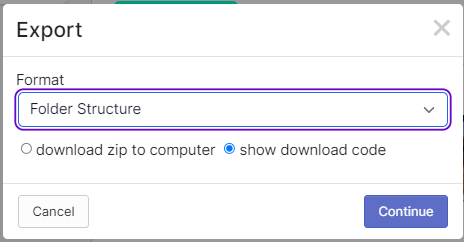

Bu şekilde ayarlamalar yapıldıktan sonra "Continue" butonuna basılır ve "Terminal" sekmesindeki kod kopyalanır. Veri Setinin Hazırlanması & Alınması bölümündeki ilk kod bloğuna yapıştırılır.

Veri setindeki görüntüler hem artırım hem de ön işleme yapılmış bir şekilde hazır.

## Importların yapılması

Kodların çalışabilmesi için paketlerin import edilmesi gerekir

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd

Pandas kütüphanesinde gözükecek olan değerlerde(Performans sonuçları) virgülden sonra 4 hanenin görünmesini sağlar.

In [2]:
pd.set_option("display.precision", 4)

## Veri Setinin Hazırlanması & Alınması

In [3]:
# Roboflow'dan veriler çekilir ve indirilen rar çıkarılır
!curl -L "https://app.roboflow.com/ds/heC0AfEQQR?key=llWAU66Qpl" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   889  100   889    0     0   1848      0 --:--:-- --:--:-- --:--:--  1844
100 93.7M  100 93.7M    0     0  78.8M      0  0:00:01  0:00:01 --:--:--  263M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: test/
   creating: test/Angus/
 extracting: test/Angus/1890225-xMDz3s_jpg.rf.6484a7fe8ba3239bba235d6c2f328d25.jpg  
 extracting: test/Angus/angus_3_jpg.rf.3cd264bc23cbb48fb49bdabb9e0c8a0f.jpg  
 extracting: test/Angus/c04328d1-dda1-4648-a82e-61258b5dd352_jpg.rf.f5c824be33d7fe9fbfa0fc7bcc7ac4ef.jpg  
 extracting: test/Angus/ed2d0588f340e97677d88037b9856e86_jpg.rf.b03383bf04ae223d95afa05aa35d2ea1.jpg  
 extracting: test/Angus/kara-angus-danalar-hazir-goruntu__k10671180_jpg.rf.c43f24136c4efe4de7df14c38871f4bf.jpg  
   creating: test/Belgium Blue/
 extracting: test/Belgium Blue/000010202264_JUSTIN_de_lArche

## Model Seçimi & Ayarlanması

### Model Seçimi

Model Seçimi, dropdowndan istenilen model seçilebilir. Eğer farklı model kullanılmak isteniyorsa map değişkenine key:value eşleşmesinde eklenebilir.

In [4]:
model_name = "mobilenet_v2_140_224" # @param ['inception_v2','efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/classification/5",
  "inception_v2": "https://tfhub.dev/google/imagenet/inception_v2/classification/5",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_v2": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

IMAGE_SIZE = (pixels, pixels)

print(f"Selected model: {model_name} : {model_handle}")

Selected model: mobilenet_v2_140_224 : https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4


### Modelin Hiperparametrelerinin & Veri Seti Yolunun Ayarlanması

Seçtiğimiz modele göre hiperparametre değerleri değişmelidir. Örnek olarak MobileNetV2 modeli 224 x 224 pixel olarak görüntüleri almalıdır. Başka bir modelde bu değer 300 x 300px olabilir.

Veri seti yolu da bu kodun içinde belirlenir ve veri seti buradan çekilir.

In [5]:
# Seçilen modele göre görüntü boyutları ayarlanır.
IMAGE_SHAPE = IMAGE_SIZE

# Eğitim ve doğrulama için klasör konumları belirlenir.
TRAINING_DATA_DIR = str('/content/train/')
VALID_DATA_DIR = str('/content/valid/')

# Eğitim ve test verileri alınır
valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255).flow_from_directory(VALID_DATA_DIR, 
                                                                                                            shuffle=True, 
                                                                                                            target_size=IMAGE_SHAPE)
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255).flow_from_directory(TRAINING_DATA_DIR,
                                                                                                      shuffle=True,
                                                                                                      target_size=IMAGE_SHAPE)

Found 54 images belonging to 10 classes.
Found 1302 images belonging to 10 classes.


Veri setindeki sınıfların klasör isimlerine göre alınması yapılır.

In [6]:
# Veri Seti sınıfları alınır ve dataset_labels değişkenine aktarılır
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])

print(dataset_labels)

['Angus' 'Belgium Blue' 'Brown Swiss' 'Charolais' 'Hereford' 'Holstein'
 'Jersey' 'Manda' 'Simmental' 'Swedish Red']


Modelin katmanları belirlenir.
Modelin kendi katmanlarının yanında aşırı uymayı(over-fitting) azaltmak için %40'lık Dropout ve bir adet de Dense katmanı eklenmiştir. İsteğe bağlı olarak değişiklikler yapılabilir.

Sonrasında model oluşturulur ve derlenir. Derlenirken optimizer, loss ve diğer metrikler ayarlanabilir. Adam optimizerı yerine SGD, categorical_crossentropy loss fonksiyonu yerine ise Poisson fonksiyonu kullanılabilir.

In [7]:
# Seçilen modele göre model hazırlanır
print(model_name)

# Katmanlar burada belirlenir, isteğe göre eklenip çıkarılabilir.
model = tf.keras.Sequential([
                             hub.KerasLayer(model_handle,output_shape=[1280],trainable=False),
                             tf.keras.layers.Dropout(0.4),
                             tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
                             ])
# Model oluşturulur
model.build([None, pixels, pixels, 3])

# Modelin parametreleri gibi detayları gösterilir
model.summary()

# Model derlenir ve izlenecek parametreler belirlenir
model.compile(
    optimizer=tf.keras.optimizers.Adam(), # Optimizer
    loss='categorical_crossentropy', # Loss
    metrics=[
             'acc', # Doğruluk
             tf.keras.metrics.Precision(), # Kesinlik
             tf.keras.metrics.Recall(), # Duyarlılık
             tf.keras.metrics.AUC( # Area Under the Curve (AUC)
                 num_thresholds=200,
                 curve="ROC", # ROC eğrisine göre
                 summation_method="interpolation")
             ])

mobilenet_v2_140_224
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1792)              4363712   
                                                                 
 dropout (Dropout)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 10)                17930     
                                                                 
Total params: 4,381,642
Trainable params: 17,930
Non-trainable params: 4,363,712
_________________________________________________________________


## Model Eğitimi

Bu kısımda model fit fonksiyonu ile eğitilir. Fonksiyonun içinde eğitim veri seti, epoch(tekrar eğitim) değeri, epoch başına uygulanacak adım sayısı, doğrulama veri seti ve doğrulama verisinde epoch başına uygulanacak adım sayısı verilir.

(Örnek Sayısı / Batch Size) ile epoch başına uygulanacak olan adım sayısı kolaylıkla bulunabilir.

**Batch Size ne kadar düşük olursa veya Epoch ne kadar yüksek olursa o kadar yavaş, tersi olan durumda ise o kadar hızlı ama tutarsız eğitim gerçekleşir.**

In [8]:
# Epoch başına işlenecek olan adım sayısı belirlenir. (Örnek)/(Batch Size) ile bulunur 
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

# Modelin asıl eğitim kısmı
hist = model.fit(
    train_generator, # Eğitim verisi
    epochs=100, # Kaç kere eğitileceği
    verbose=1, # Eğitim izlenecek mi? 0 = Hayır 1 = Evet
    steps_per_epoch=steps_per_epoch, # Epoch başına adım sayısı
    validation_data=valid_generator, # Doğrulama verisi
    validation_steps=val_steps_per_epoch # Doğrulamada epoch başına adım sayısı
    ).history

Epoch 1/100
41/41 [==============================] - 24s 241ms/step - loss: 2.0943 - acc: 0.2988 - precision: 0.4242 - recall: 0.1183 - auc: 0.7370 - val_loss: 1.2752 - val_acc: 0.6667 - val_precision: 0.7692 - val_recall: 0.1852 - val_auc: 0.9456
Epoch 2/100
41/41 [==============================] - 8s 201ms/step - loss: 1.1975 - acc: 0.5883 - precision: 0.7517 - recall: 0.4232 - auc: 0.9180 - val_loss: 1.0122 - val_acc: 0.7407 - val_precision: 0.8636 - val_recall: 0.3519 - val_auc: 0.9594
Epoch 3/100
41/41 [==============================] - 8s 199ms/step - loss: 0.8842 - acc: 0.6974 - precision: 0.8103 - recall: 0.5545 - auc: 0.9576 - val_loss: 0.8247 - val_acc: 0.7407 - val_precision: 0.8276 - val_recall: 0.4444 - val_auc: 0.9765
Epoch 4/100
41/41 [==============================] - 8s 199ms/step - loss: 0.6930 - acc: 0.7673 - precision: 0.8597 - recall: 0.6590 - auc: 0.9750 - val_loss: 0.8322 - val_acc: 0.7593 - val_precision: 0.8182 - val_recall: 0.5000 - val_auc: 0.9688
Epoch 5/100

## Performans Testi

Model eğitildikten sonra doğrulama veri seti üzerinden model çalıştırılır ve girilen metriklere göre performans sonuçları elde edilir.

In [9]:
loss, acc, precision, recall, auc = model.evaluate(valid_generator) # kayıp, doğruluk, kesinlik, duyarlılık ve auc değerleri model doğrulama verileriyle çalıştırılarak elde edilir.
print("loss: ",loss,"acc: ",acc,"precision: ",precision,"recall: ",recall,"auc: ",auc)

2/2 [==============================] - 0s 91ms/step - loss: 0.8320 - acc: 0.8148 - precision: 0.8302 - recall: 0.8148 - auc: 0.9533
loss:  0.8319569230079651 acc:  0.8148148059844971 precision:  0.8301886916160583 recall:  0.8148148059844971 auc:  0.9533227682113647


## TensorFlow Modelinin Kaydedilmesi

Modelin eğitimi, performans testleri bittikten sonra eğer doğru eğitildiğinden emin olursanız kaydetme aşamasına geçebilirsiniz. Öncelikle TensorFlow modeli kaydedilir, ardından aşağıdaki bölümlerde bu kaydedilen model TensorFlow Lite modeline çevrilecektir.

In [10]:
# Modelin kaydedileceği yolun belirlenmesi
SAVED_MODEL = "saved_models/"+model_name+""
# Modelin TensorFlow formatında kaydedilmesi
model.save(SAVED_MODEL)
# Kaydedilen modelin saved_model değişkenine yüklenmesi
saved_model = tf.keras.models.load_model(SAVED_MODEL)
# custom_objects={'KerasLayer':hub.KerasLayer}

INFO:tensorflow:Assets written to: saved_models/mobilenet_v2_140_224/assets


INFO:tensorflow:Assets written to: saved_models/mobilenet_v2_140_224/assets


## Modelde Çıkarım Testi

Model kaydedildikten sonra model yüklenir ve çıkarım testleri gerçekleştirilir.

Testte doğrulama veri setinden batch büyüklükleri alınır ve doğrulama veri seti tahmin ettirilir. 
Tahminlemeden sonra görselleştirmeye hazırdır.

In [11]:
# Doğrulama verilerinin batch değerlerinin elde edilmesi
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [12]:
# Kaydedilen modelin sınıf sınıf tahmin edilmesi
tf_model_predictions = saved_model.predict(val_image_batch)
# Tahminlerin dataframe olarak aktarılması
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
# Sınıfların sütun olarak atanması
tf_pred_dataframe.columns = dataset_labels
print("İlk 5 değerin doğruluk değerleri")
tf_pred_dataframe.head()

İlk 5 değerin doğruluk değerleri


,Angus,Belgium Blue,Brown Swiss,Charolais,Hereford,Holstein,Jersey,Manda,Simmental,Swedish Red
0,6.1982e-08,1.8166e-08,2.2277e-08,6.4075e-07,9.4789e-01,5.6890e-09,2.0435e-05,1.2584e-06,0.0521,1.7824e-05
1,4.1085e-05,3.7265e-02,8.4289e-03,3.2515e-05,3.2854e-03,4.3091e-02,6.0379e-02,3.0841e-03,0.2856,5.5875e-01
2,2.0317e-04,9.9669e-01,9.5927e-06,2.5949e-03,2.9917e-05,2.6274e-04,4.5218e-05,2.1032e-07,0.0002,4.3074e-06
3,2.4091e-04,1.4445e-04,6.4615e-04,9.2147e-04,6.0957e-01,2.3143e-06,1.4820e-02,1.4079e-04,0.3730,4.7142e-04
4,1.7188e-02,2.4331e-03,6.7790e-01,4.0463e-04,1.7786e-05,8.6130e-02,1.6533e-01,5.3440e-03,0.0452,1.0278e-04


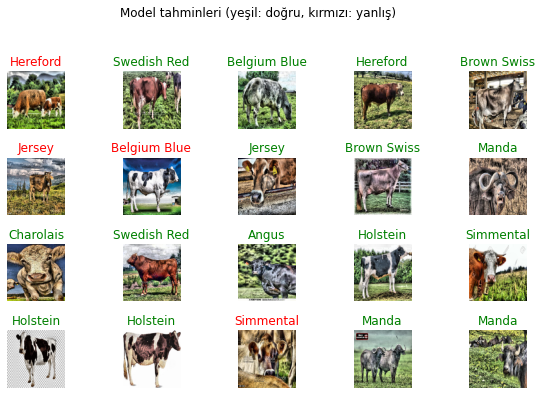

In [13]:
# Tahmin sonuçlarının görsel olarak gösterilmesi
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
  _ = plt.suptitle("Model tahminleri (yeşil: doğru, kırmızı: yanlış)")

## TensorFlow modelini TensorFlow Lite modeline çevirmek


In [14]:
!mkdir "tflite_models"
# TensorFlow modelinin yolunu alır
ppath = "./saved_models/" + model_name + ""
print(ppath)
# TFLite Converter ile TensorFlow modeli TFLite modeline çevrilir
converter = tf.lite.TFLiteConverter.from_saved_model(ppath)
tflite_model = converter.convert()
# Belirlenen yola TFLite modeli yazılır
with open('/content/tflite_models/'+model_name+'.tflite', 'wb') as f:
  f.write(tflite_model)

./saved_models/mobilenet_v2_140_224


In [15]:
# TFLite ve TensorFlow modeli indirmek için zip dosyasına atılır
!zip -r /content/tflite_models.zip /content/tflite_models
!zip -r /content/saved_models.zip /content/saved_models

  adding: content/tflite_models/ (stored 0%)
  adding: content/tflite_models/mobilenet_v2_140_224.tflite (deflated 7%)
  adding: content/saved_models/ (stored 0%)
  adding: content/saved_models/mobilenet_v2_140_224/ (stored 0%)
  adding: content/saved_models/mobilenet_v2_140_224/keras_metadata.pb (deflated 82%)
  adding: content/saved_models/mobilenet_v2_140_224/saved_model.pb (deflated 91%)
  adding: content/saved_models/mobilenet_v2_140_224/assets/ (stored 0%)
  adding: content/saved_models/mobilenet_v2_140_224/variables/ (stored 0%)
  adding: content/saved_models/mobilenet_v2_140_224/variables/variables.index (deflated 78%)
  adding: content/saved_models/mobilenet_v2_140_224/variables/variables.data-00000-of-00001 (deflated 7%)
